In [28]:
import glob
import json
import re
import pandas as pd
import sys
import pickle
import numpy as np
import copy
import math
import ipdb
import matplotlib.pyplot as plt



season = "high"

data_folder = '/Users/sergiocamelo/Dropbox/Sergio-Joann/StandardizedData/'

# This script calculates the results of efficiency
folder_instances = data_folder+"instances"
sys.path.insert(0, '/Users/sergiocamelo/Dropbox/Sergio-Joann/Code/LowerBoundsC')
import VRPClass
import road_distance


truck_loads = []

In [44]:
# Get coordinates of farmers, mills and trucks
dim_trucks = pd.read_csv(data_folder+'dim_trucks.csv')
dim_farmers = pd.read_csv(data_folder+'dim_farmers.csv')
dim_mills = pd.read_csv(data_folder+'dim_mills.csv')
dim_middlemen = pd.read_csv(data_folder+'dim_middlemen.csv')

positions_dict = {}
for i, row in dim_mills.iterrows():
    positions_dict[row["code"]] = (row['latitude'], row['longitude'])
for i, row in dim_farmers.iterrows():
    positions_dict[row["farmer_id"]+'-'+str(row["plot_number"])] = (row['latitude'], row['longitude'])
for i, row in dim_middlemen.iterrows():
    positions_dict[row["cluster_id"]] = (row['latitude'], row['longitude'])
for i, row in dim_trucks.iterrows():
    positions_dict[row["truck_id"]] = positions_dict[float(row["cluster_id"])]
    
def get_distance(a, b, mapping = None, detailed = True):
    if a[0] == 'h':
        m_a = mapping[a][0]
    elif a[0] == 'n':
        m_a = mapping[a]
    else:
        m_a = a
    if b[0] == 'h':
        m_b = mapping[b][0]
    elif b[0] == 'n':
        m_b = mapping[b]
    else:
        m_b = b
    return road_distance.road_distance(positions_dict[m_a],positions_dict[m_b], detailed=detailed)

def path_distance(path, mapping, mill):
    surfaces = ['access','gravel','asphalt','dirt','unknown']
    new_path = copy.copy(path)
    new_path.insert(len(path)-1, mill)
    result = None
    for i in range(len(new_path)-1):
        if not result:
            result = get_distance(new_path[i],new_path[i+1],mapping)
            #ipdb.set_trace()
        else:
            dist = get_distance(new_path[i],new_path[i+1],mapping)

            result["distance"] += dist["distance"]
            result["time"] += dist["time"]
            for k in dist["detailed_distance"].keys():
                if k in result["detailed_distance"].keys():
                    result["detailed_distance"][k]+=dist["detailed_distance"][k]
                    result["detailed_time"][k]+=dist["detailed_time"][k]
                else:
                    result["detailed_distance"][k]=dist["detailed_distance"][k]
                    result["detailed_time"][k]=dist["detailed_time"][k]
    
    for s in surfaces:
        if not(s in result["detailed_distance"].keys()):
            result["detailed_distance"][s] = 0
            result["detailed_time"][s] = 0
    
    return result
        
        

In [55]:
def clean_dict(d):
    d = json.loads(d)
    for k in d.keys():
        if d[k] == 0:
            del d[k]
    return d
dim_middlemen = dim_middlemen[pd.notnull(dim_middlemen['cluster_id'])]
dim_middlemen['cluster_id'] = dim_middlemen['cluster_id'].apply(int).apply(str)
dim_middlemen['trucks'] = dim_middlemen['trucks'].apply(clean_dict)

ValueError: Expecting property name: line 1 column 2 (char 1)

In [32]:
# Remove repeated farmers
def remove_repetitions(data,N,vrp):
    
    
    new_ub = 0
    for t in data['routes'].keys():
        for i,route in enumerate(data['routes'][t]):
            route["distance"] = vrp.distance_path([t]+route['route']+[t])
            new_ub += route["distance"]
    if (new_ub!=data['z_ub']):
        print("Error in distance calculation", new_ub,data['z_ub'])
    
    ocurrences = dict(zip(N,[0]*len(N)))
    for t in data['routes'].keys():
        for route in data['routes'][t]:
            for n in route['route']:
                ocurrences[n]+=1

    for n in N:
        if ocurrences[n]>1:
            
            print("Node %s is repeated" % n)
            print data['routes']
            # Calculate gain from removing it
            min_gain = float('inf')
            min_route = None
            min_coord = None
            for t in data['routes'].keys():
                for i,route in enumerate(data['routes'][t]):
                    if n in route['route']:
                        route_with = route['route']
                        route_without = [m for m in route['route'] if m!=n]
                        dist_before = vrp.distance_path([t]+route_with+[t])
                        dist_after = vrp.distance_path([t]+route_without+[t])
                        gain = dist_before - dist_after
                        if gain <= min_gain:
                            min_gain = gain
                            min_route = copy.copy(route_with)
                            min_coord = (t,i)
                        route['route'] = route_without
            data['routes'][min_coord[0]][min_coord[1]]['route'] = min_route
            
            for t in data['routes'].keys():
                for i,route in enumerate(data['routes'][t]):
                    route["distance"] = vrp.distance_path([t]+route['route']+[t])
                    new_ub += route["distance"]
            data['z_ub'] = new_ub  
            print data['routes']
        if ocurrences[n]<1:
            print("Error, there is a node without pickup route")

    # Remove repeated farmers
    #def remove_repetitions(data,N,vrp):
    ocurrences = dict(zip(N,[0]*len(N)))
    for t in data['routes'].keys():
        for route in data['routes'][t]:
            for n in route['route']:
                ocurrences[n]+=1

    for n in N:
        if ocurrences[n]>1:
            print("Error, fixing not successful")
        if ocurrences[n]<1:
            print("Error, fixing not successful")
            
            
    # Recalculate Upper Bound
    old_ub = data['z_ub']
    new_ub = 0
    for t in data['routes'].keys():
        for i,route in enumerate(data['routes'][t]):
            route["distance"] = vrp.distance_path([t]+route['route']+[t])
            new_ub += route["distance"]
    data['z_ub'] = new_ub  
    if old_ub < new_ub:
        print("Error in new upper bound")
        print(old_ub, new_ub)

    gap = (data['z_ub']-data['z_lb'])/data['z_ub']
    if gap < -10**(-8):
        print("Error, negative gap")

In [33]:
# Load daily results
instances = glob.glob(folder_instances+"/daily/*_result.json")
print("There is a total of %d daily instances"%len(instances))
daily_results = {}
instances_parsed = []

z_ub = 0
z_lb = 0
for instance in instances:
    # Load instance
    with open(instance) as f:
        data = json.load(f)
    name_instance = re.search('/daily/(.*)_result.json',instance).group(1)

    # Get day and cluster
    day = name_instance.split('_')[4]
    cluster = name_instance.split('_')[2]
    
    # Get the data of this instance
    instance_data = pickle.load( open( folder_instances+"/daily/daily_cluster_"+str(cluster)+"_day_"+str(day) + ".p", "rb" ) )
    locals().update(instance_data)
    vrp = VRPClass.VRP(H, N, H_p, N_p, quantities, capacities, type_dist, M = M, M_p = M_p, distance_matrix = distance)
    data['mapping'] = mapping

    # Get farmers served
    farmers = [node for node in data['mapping'].keys() if node[0] == 'n']
    farmers_index = [data['mapping'][f] for f in farmers]
    # Make sure these farmers are part of the routes
    farmers_inroute = [n for node in [route['route'] for key, routes in data['routes'].iteritems() if len(routes)>0 for route in routes] for n in node]
    if (set(farmers_inroute)!=set(farmers)):
        print("error")
        
    # Fix farmers that are picked up more than once
    remove_repetitions(data,N,vrp)
    
    instances_parsed.append({
        "n_nodes": len([n for n in data['mapping'].keys() if n[0]=='n']),
        "cluster": cluster,
        "day": day,
        "n_trucks": len([n for n in data['mapping'].keys() if n[0]=='h']),
        "z_ub":data['z_ub'],
        "z_lb":data['z_lb'],
        "gap":(data['z_ub']-data['z_lb'])/data['z_ub'],
        "nodes_served":[data['mapping'][n] for n in data['mapping'].keys() if n[0]=='n']
    })
    
    for t in data['routes'].keys():
        for route in data['routes'][t]:
            detailed_dist = path_distance([t]+route['route']+[t],mapping,'SKIP')
            truck_loads.append({
                    "type":"daily",
                    "cluster":data['mapping'][t][2],
                    "truck":data['mapping'][t][0],
                    "day":data['mapping'][t][1],
                    "max_load":route["max_load"],
                    "load":np.sum([quantities[n] for n in route['route']]),
                    "load_perc":np.sum([quantities[n] for n in route['route']])/(route["max_load"]+0.0),
                    "n_farmers":len(set(route["route"])),
                    "distance":vrp.distance_path([t]+route['route']+[t]),
                    "detailed_distance":detailed_dist['distance'],
                    "gravel":detailed_dist['detailed_distance']['gravel'],
                    "asphalt":detailed_dist['detailed_distance']['asphalt'],
                    "access":detailed_dist['detailed_distance']['access'],
                    "dirt":detailed_dist['detailed_distance']['dirt'],
                    "unknown":detailed_dist['detailed_distance']['unknown'],
                    "road_time":detailed_dist['time'],
                    "farmers":[data['mapping'][n] for n in route["route"] if n[0]=='n']
                })
    #print(instance)
    #print((data['z_ub']-data['z_lb'])/data['z_ub'])

    
    # Get upper and lower bounds
    z_ub += data['z_ub']
    z_lb += data['z_lb']
print z_ub
print z_lb
print((z_ub-z_lb)/z_ub)
daily_df = pd.DataFrame(instances_parsed)
daily_df.to_csv(data_folder+("tables_for_report/%s/runs_daily.csv"%season),index=False)

There is a total of 98 daily instances
Node n_1 is repeated
{u'h_0': [{u'load': 65, u'max_load': 90, u'route': [u'n_1', u'n_0', u'n_4'], 'distance': 49293.840782}], u'h_1': [{u'load': 50, u'max_load': 90, u'route': [u'n_3', u'n_2', u'n_1'], 'distance': 47213.660602}]}
{u'h_0': [{u'load': 65, u'max_load': 90, u'route': [u'n_0', u'n_4'], 'distance': 48039.447582}], u'h_1': [{u'load': 50, u'max_load': 90, u'route': [u'n_3', u'n_2', u'n_1'], 'distance': 47213.660602}]}
Node n_2 is repeated
{u'h_0': [{u'load': 73, u'max_load': 90, u'route': [u'n_2', u'n_0', u'n_3'], 'distance': 54758.25480000001}], u'h_1': [{u'load': 60, u'max_load': 90, u'route': [u'n_2', u'n_1'], 'distance': 49458.78128}]}
{u'h_0': [{u'load': 73, u'max_load': 90, u'route': [u'n_0', u'n_3'], 'distance': 53531.65494800001}], u'h_1': [{u'load': 60, u'max_load': 90, u'route': [u'n_2', u'n_1'], 'distance': 49458.78128}]}
5384972.772930001
5100318.53931
0.05286084918572521


In [34]:
# Load spatial results
instances = glob.glob(folder_instances+"/spatial/*_result.json")
print("There is a total of %d daily instances"%len(instances))
daily_results = {}
instances_parsed = []


z_ub = 0
z_lb = 0
for instance in instances:
    print(instance)
    # Load instance
    with open(instance) as f:
        data = json.load(f)
    name_instance = re.search('/spatial/(.*)_result.json',instance).group(1)

    # Get day and cluster
    day = name_instance.split('_')[2]
    
    # Get the data of this instance
    instance_data = pickle.load( open( folder_instances+"/spatial/spatial_day_"+str(day) + ".p", "rb" ) )
    locals().update(instance_data)
    vrp = VRPClass.VRP(H, N, H_p, N_p, quantities, capacities, type_dist, M = M, M_p = M_p, distance_matrix = distance)


    # Get farmers served
    farmers = [node for node in data['mapping'].keys() if node[0] == 'n']
    farmers_index = [data['mapping'][f] for f in farmers]
    # Make sure these farmers are part of the routes
    farmers_inroute = [n for node in [route['route'] for key, routes in data['routes'].iteritems() if len(routes)>0 for route in routes] for n in node]
    if (set(farmers_inroute)!=set(farmers)):
        print("error")
        print(farmers_inroute)
        print(farmers)
        print(name_instance)
        print data['z_lb']
        print data['z_ub']
        
    # Fix farmers that are picked up more than once
    remove_repetitions(data,N,vrp)
    
    # Get upper and lower bounds
    z_ub += data['z_ub']
    z_lb += data['z_lb']
    
    instances_parsed.append({
        "n_nodes": len([n for n in data['mapping'].keys() if n[0]=='n']),
        "day": day,
        "n_trucks": len([n for n in data['mapping'].keys() if n[0]=='h']),
        "z_ub":data['z_ub'],
        "z_lb":data['z_lb'],
        "gap":(data['z_ub']-data['z_lb'])/data['z_ub'],
        "nodes_served":[data['mapping'][n] for n in data['mapping'].keys() if n[0]=='n']
    })
    
    for t in data['routes'].keys():
        for route in data['routes'][t]:
            detailed_dist = path_distance([t]+route['route']+[t],mapping,'SKIP')
            truck_loads.append({
                    "type":"spatial",
                    "cluster":data['mapping'][t][2],
                    "truck":data['mapping'][t][0],
                    "day":data['mapping'][t][1],
                    "max_load":route["max_load"],
                    "load":np.sum([quantities[n] for n in route['route']]),
                    "load_perc":np.sum([quantities[n] for n in route['route']])/(route["max_load"]+0.0),
                    "n_farmers":len(set(route["route"])),
                    "distance":vrp.distance_path([t]+route['route']+[t]),
                    "detailed_distance":detailed_dist['distance'],
                    "gravel":detailed_dist['detailed_distance']['gravel'],
                    "asphalt":detailed_dist['detailed_distance']['asphalt'],
                    "access":detailed_dist['detailed_distance']['access'],
                    "dirt":detailed_dist['detailed_distance']['dirt'],
                    "unknown":detailed_dist['detailed_distance']['unknown'],
                    "road_time":detailed_dist['time'],
                    "farmers":[data['mapping'][n] for n in route["route"] if n[0]=='n']
            })
print z_ub
print z_lb
print((z_ub-z_lb)/z_ub)
spatial_df = pd.DataFrame(instances_parsed)

spatial_df.to_csv(data_folder+("tables_for_report/%s/runs_spatial.csv" % season),index=False)

There is a total of 14 daily instances
/Users/sergiocamelo/Dropbox/Sergio-Joann/StandardizedData/instances/spatial/spatial_day_0_result.json
('Error in distance calculation', 268591.433318, 268591.43331800005)
/Users/sergiocamelo/Dropbox/Sergio-Joann/StandardizedData/instances/spatial/spatial_day_10_result.json
/Users/sergiocamelo/Dropbox/Sergio-Joann/StandardizedData/instances/spatial/spatial_day_11_result.json
Node n_19 is repeated
{u'h_6': [{u'load': 77, u'max_load': 90, u'route': [u'n_19', u'n_24', u'n_5', u'n_16'], 'distance': 20931.205226}], u'h_7': [], u'h_4': [], u'h_5': [], u'h_2': [], u'h_3': [{u'load': 85, u'max_load': 90, u'route': [u'n_10', u'n_8', u'n_9', u'n_11'], 'distance': 36507.637925999996}], u'h_0': [], u'h_1': [], u'h_8': [{u'load': 74, u'max_load': 90, u'route': [u'n_12', u'n_22', u'n_21', u'n_6', u'n_17'], 'distance': 33977.716073999996}], u'h_9': [], u'h_10': [{u'load': 86, u'max_load': 90, u'route': [u'n_0', u'n_4', u'n_3', u'n_2', u'n_1', u'n_14', u'n_13'], '

In [35]:
# Load temporal results
instances = glob.glob(folder_instances+"/temporal/*_result.json")
print("There is a total of %d daily instances"%len(instances))
daily_results = {}
instances_parsed = []


z_ub = 0
z_lb = 0
for instance in instances:
    print(instance)
    # Load instance
    with open(instance) as f:
        data = json.load(f)
    name_instance = re.search('/temporal/(.*)_result.json',instance).group(1)

    # Get day and cluster
    cluster = name_instance.split('_')[2]
    
    # Get the data of this instance
    instance_data = pickle.load( open( folder_instances+"/temporal/temporal_cluster_"+str(cluster) + ".p", "rb" ) )
    locals().update(instance_data)
    vrp = VRPClass.VRP(H, N, H_p, N_p, quantities, capacities, type_dist, M = M, M_p = M_p, distance_matrix = distance)


    # Get farmers served
    farmers = [node for node in data['mapping'].keys() if node[0] == 'n']
    farmers_index = [data['mapping'][f] for f in farmers]
    # Make sure these farmers are part of the routes
    farmers_inroute = [n for node in [route['route'] for key, routes in data['routes'].iteritems() if len(routes)>0 for route in routes] for n in node]
    if (set(farmers_inroute)!=set(farmers)):
        print("error")
        print(farmers_inroute)
        print(farmers)
        print(name_instance)
        
    # Get upper and lower bounds
    z_ub += data['z_ub']
    z_lb += data['z_lb']
    
    # Fix farmers that are picked up more than once
    remove_repetitions(data,N,vrp)
    
    instances_parsed.append({
        "n_nodes": len([n for n in data['mapping'].keys() if n[0]=='n']),
        "cluster": cluster,
        "n_trucks": len([n for n in data['mapping'].keys() if n[0]=='h']),
        "z_ub":data['z_ub'],
        "z_lb":data['z_lb'],
        "gap":(data['z_ub']-data['z_lb'])/data['z_ub'],
        "nodes_served":[data['mapping'][n] for n in data['mapping'].keys() if n[0]=='n']
    })
    
    for t in data['routes'].keys():
        for route in data['routes'][t]:
            detailed_dist = path_distance([t]+route['route']+[t],mapping,'SKIP')
            truck_loads.append({
                    "type":"temporal",
                    "cluster":int(cluster),
                    "truck":data['mapping'][t][0],
                    "day":-1,
                    "max_load":route["max_load"],
                    "load":np.sum([quantities[n] for n in route['route']]),
                    "load_perc":np.sum([quantities[n] for n in route['route']])/(route["max_load"]+0.0),
                    "n_farmers":len(set(route["route"])),
                    "distance":vrp.distance_path([t]+route['route']+[t]),
                    "detailed_distance":detailed_dist['distance'],
                    "gravel":detailed_dist['detailed_distance']['gravel'],
                    "asphalt":detailed_dist['detailed_distance']['asphalt'],
                    "access":detailed_dist['detailed_distance']['access'],
                    "dirt":detailed_dist['detailed_distance']['dirt'],
                    "unknown":detailed_dist['detailed_distance']['unknown'],
                    "road_time":detailed_dist['time'],
                    "farmers":[data['mapping'][n] for n in route["route"] if n[0]=='n']
            })

print z_ub
print z_lb
print((z_ub-z_lb)/z_ub)
temporal_df = pd.DataFrame(instances_parsed)
temporal_df.to_csv(data_folder+("tables_for_report/%s/runs_temporal.csv" % season),index=False)

There is a total of 9 daily instances
/Users/sergiocamelo/Dropbox/Sergio-Joann/StandardizedData/instances/temporal/temporal_cluster_108_result.json
/Users/sergiocamelo/Dropbox/Sergio-Joann/StandardizedData/instances/temporal/temporal_cluster_13_result.json
('Error in distance calculation', 1090640.3977240003, 1090640.397724)
Error in new upper bound
(1090640.397724, 1090640.3977240003)
/Users/sergiocamelo/Dropbox/Sergio-Joann/StandardizedData/instances/temporal/temporal_cluster_23_result.json
/Users/sergiocamelo/Dropbox/Sergio-Joann/StandardizedData/instances/temporal/temporal_cluster_35_result.json
Node n_44 is repeated
{u'h_0': [{u'load': 88, u'max_load': 90, u'route': [u'n_5', u'n_9', u'n_7', u'n_0', u'n_8', u'n_19'], 'distance': 33283.176911999995}, {u'load': 90, u'max_load': 90, u'route': [u'n_17', u'n_2', u'n_33'], 'distance': 29937.965851999998}, {u'load': 88, u'max_load': 90, u'route': [u'n_45', u'n_43', u'n_6', u'n_4', u'n_38', u'n_32'], 'distance': 30644.724832}, {u'load': 90

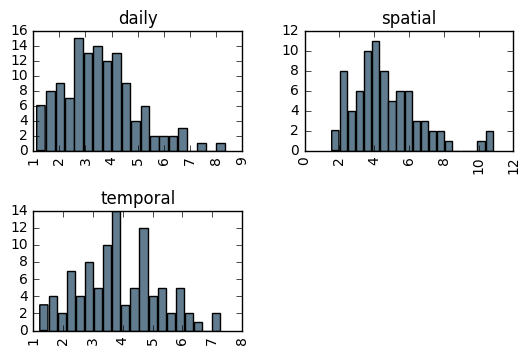

In [36]:
truck_loads_df = pd.DataFrame(truck_loads)
truck_loads_df['load'] = truck_loads_df['load']*10
truck_loads_df.to_csv(data_folder+("tables_for_report/%s/truck_data.csv"% season),index=False)

# Load the truck data
truck_data = pd.read_csv(data_folder+"dim_trucks.csv")
truck_data = truck_data[[t in np.unique(truck_loads_df['truck']) for t in truck_data['truck_id']]]
truck_data['cluster_id'] = truck_data['cluster_id'].apply(str)
truck_data['capacity'] = truck_data['capacity']*10
truck_data['tmp']=1

types_df = pd.DataFrame({'type':['daily','spatial','temporal']})
types_df['tmp'] = 1
days_df = pd.DataFrame({'day':list(range(14))})
days_df['tmp'] = 1

truck_data_aux = truck_data.merge(days_df,on=['tmp']).merge(types_df,on=['tmp'])
truck_data_aux = truck_data_aux.drop('tmp', axis=1)

# Fill up the days of the temporal truck_loads
day_counts = {t:0 for t in np.unique(truck_loads_df['truck'])}
for i,row in truck_loads_df.iterrows():
    t = row['truck']
    if row['type'] == 'temporal':
        truck_loads_df.loc[i,'day'] = day_counts[t]
        day_counts[t] = day_counts[t] + 1


# Replace empty rows of truck_loads_df
truck_loads_df_full = truck_loads_df.merge(truck_data_aux, how='right',left_on=['type','day','truck'],right_on=['type','day','truck_id'])
truck_loads_df_full = truck_loads_df_full.drop(['farmers','load_perc','truck'], axis=1)

surfaces = ["gravel", "asphalt", "access", "dirt","unknown"]

columns = ["detailed_distance", "road_time"] + surfaces

truck_loads_df_full['distance'] = truck_loads_df_full['distance'].apply(lambda x: 0 if math.isnan(x) else x)
truck_loads_df_full['load'] = truck_loads_df_full['load'].apply(lambda x: 0 if math.isnan(x) else x)
truck_loads_df_full['max_load'] = truck_loads_df_full['max_load'].apply(lambda x: 0 if math.isnan(x) else x)
truck_loads_df_full['n_farmers'] = truck_loads_df_full['n_farmers'].apply(lambda x: 0 if math.isnan(x) else x)
truck_loads_df_full['cluster'] = truck_loads_df_full['cluster_id'] 
for c in columns:
    truck_loads_df_full[c] = truck_loads_df_full[c].apply(lambda x: 0 if math.isnan(x) else x)


truck_loads_df_full = truck_loads_df_full[['cluster','truck_id','day','type','distance','load','max_load','capacity','n_farmers']+columns]
truck_loads_df_full = truck_loads_df_full.sort_values(by=['truck_id','day','type'])
truck_loads_df_full['cluster'] = truck_loads_df_full['cluster'].apply(str)
truck_loads_df_full['day'] = truck_loads_df_full['day'].apply(int).apply(str)
truck_loads_df_full['n_trucks'] = 1
truck_loads_df_full['load_perc'] = truck_loads_df_full['load']/truck_loads_df_full['capacity']
truck_loads_df_full['load_perc_occupied'] = truck_loads_df_full['load']/truck_loads_df_full['max_load']


# Set surface participation
surfaces_perc = ["gravel_perc", "asphalt_perc", "access_perc", "dirt_perc","unknown_perc"]
for s in surfaces:
    name = s+'_perc'
    truck_loads_df_full[name] = truck_loads_df_full[s]/truck_loads_df_full["detailed_distance"]
    
truck_loads_df_full["road_time"] = truck_loads_df_full["road_time"]/(60.0*60.0)
truck_loads_df_full["total_time"] = truck_loads_df_full["road_time"] + truck_loads_df_full["n_farmers"]*0.5

columns_print = ["road_time","total_time"] + surfaces_perc
    
truck_loads_df_print = truck_loads_df_full.sort_values(by=['cluster','truck_id', 'day','type'])[['cluster','truck_id','day','type','distance','load','capacity','load_perc','max_load','load_perc_occupied','n_farmers','n_trucks']+columns_print]
truck_loads_df_print = truck_loads_df_print.reset_index(drop=True)
truck_loads_df_print.to_csv(data_folder+("tables_for_report/%s/daily_truck_breakdown.csv" % season),index=False)
# Plot total_time
%matplotlib inline  
ax = truck_loads_df_print['total_time'][truck_loads_df_print['total_time']>0].hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e', by= truck_loads_df_print['type'][truck_loads_df_print['total_time']>0])


In [37]:
# Prepare table with cluster, day data
cluster_day_df = truck_loads_df_full[['type','cluster','day','distance','load','max_load','capacity','n_farmers','n_trucks']+columns].groupby(['cluster','day','type']).sum()
cluster_day_df = cluster_day_df.reset_index(level=['cluster','day','type'])

# Add daily data
cluster_day_df_daily = cluster_day_df[cluster_day_df['type']=='daily'].merge(daily_df[['cluster','day','z_lb']], how="left", on = ['cluster','day'])
cluster_day_df_daily['z_lb'] = cluster_day_df_daily['z_lb'].apply((lambda x: 0 if math.isnan(x) else x))
cluster_day_df_daily['gap'] = (cluster_day_df_daily['distance']-cluster_day_df_daily['z_lb'])/cluster_day_df_daily['distance']


cluster_day_df_all = pd.concat([cluster_day_df_daily, cluster_day_df[cluster_day_df['type']!='daily']], axis=0)
cluster_day_df_all['load_perc'] = cluster_day_df_all['load']/cluster_day_df_all['capacity']
cluster_day_df_all['load_perc_occupied'] = cluster_day_df_all['load']/cluster_day_df_all['max_load']


cluster_day_df_all['day'] = cluster_day_df_all['day'].apply(int)

for s in surfaces:
    name = s+'_perc'
    cluster_day_df_all[name] = cluster_day_df_all[s]/cluster_day_df_all["detailed_distance"]
columns_print = surfaces_perc

cluster_day_df_all = cluster_day_df_all.sort_values(by=['cluster','day','type'])[['cluster','day','type','distance','z_lb','gap','load','capacity','load_perc','max_load','load_perc_occupied','n_farmers','n_trucks'] + columns_print]
cluster_day_df_all = cluster_day_df_all.reset_index(drop=True)
cluster_day_df_all.to_csv(data_folder+("tables_for_report/%s/daily_cluster_breakdown.csv" % season),index=False)
#cluster_day_df_all

In [52]:
# Prepare table with cluster data
cluster_df = truck_loads_df_full[['type','cluster','day','distance','load','max_load','capacity','n_farmers','n_trucks']+columns].groupby(['cluster','type']).sum()
cluster_df = cluster_df.reset_index(level=['cluster','type'])

# Add temporal data
cluster_df_temp = cluster_df[cluster_df['type']=='temporal'].merge(temporal_df[['cluster','z_lb']], how="left", on = ['cluster'])

# Add daily data
daily_grouped = daily_df[['cluster','z_lb']].groupby(['cluster']).sum().reset_index()
cluster_df_daily = cluster_df[cluster_df['type']=='daily'].merge(daily_grouped, how="left", on = ['cluster'])
cluster_df_temp = pd.concat([cluster_df_temp, cluster_df_daily], axis=0)

cluster_df_temp['z_lb'] = cluster_df_temp['z_lb'].apply((lambda x: 0 if math.isnan(x) else x))
cluster_df_temp['gap'] = (cluster_df_temp['distance']-cluster_df_temp['z_lb'])/cluster_df_temp['distance']
cluster_df_temp['gap'] = cluster_df_temp['gap'].apply((lambda x: 0 if math.isnan(x) else x))

cluster_df_temp_all = pd.concat([cluster_df_temp, cluster_df[cluster_df['type']=='spatial']], axis=0)
cluster_df_temp_all['load_perc'] = cluster_df_temp_all['load']/cluster_df_temp_all['capacity']
cluster_df_temp_all['load_perc_occupied'] = cluster_df_temp_all['load']/cluster_df_temp_all['max_load']

for s in surfaces:
    name = s+'_perc'
    cluster_df_temp_all[name] = cluster_df_temp_all[s]/cluster_df_temp_all["detailed_distance"]
columns_print = surfaces_perc

# Join the fleet of trucks
cluster_df_temp_all = cluster_df_temp_all.merge(dim_middlemen[['cluster_id','trucks']], how="inner", left_on = ['cluster'], right_on = ['cluster_id'])


cluster_df_temp_all = cluster_df_temp_all.sort_values(by=['cluster','type'])[['cluster','type','distance','z_lb','gap','load','capacity','load_perc','max_load','load_perc_occupied','n_farmers','n_trucks']+columns_print+["trucks"]]
cluster_df_temp_all = cluster_df_temp_all.reset_index(drop=True)
cluster_df_temp_all.to_csv(data_folder+("tables_for_report/%s/cluster_breakdown.csv" % season),index=False)

In [53]:
cluster_df_temp_all

,cluster,type,distance,z_lb,gap,load,capacity,load_perc,max_load,load_perc_occupied,n_farmers,n_trucks,gravel_perc,asphalt_perc,access_perc,dirt_perc,unknown_perc,trucks
0,108,daily,7.994297e+05,702582.355761,1.211456e-01,845.0,2520,0.335317,1440.0,0.586806,42.0,28,0.389791,0.099939,0.026470,0.183178,0.258608,"{'9':2,'2':0,'1':0}"
1,108,spatial,9.674398e+05,NaN,NaN,1523.0,2520,0.604365,1620.0,0.940123,69.0,28,0.366845,0.091659,0.030540,0.225929,0.240937,"{'9':2,'2':0,'1':0}"
2,108,temporal,4.958543e+05,471399.463022,4.931854e-02,845.0,2520,0.335317,900.0,0.938889,42.0,28,0.395527,0.100703,0.042245,0.159707,0.260888,"{'9':2,'2':0,'1':0}"
3,13,daily,1.031759e+06,960769.999607,6.880370e-02,1189.0,2800,0.424643,1750.0,0.679429,52.0,42,0.361831,0.112938,0.021139,0.136417,0.275609,"{'9':2,'2':1,'1':0}"
4,13,spatial,3.249971e+05,NaN,NaN,582.0,2800,0.207857,630.0,0.923810,30.0,42,0.395072,0.107551,0.032339,0.084262,0.285493,"{'9':2,'2':1,'1':0}"
5,13,temporal,1.090640e+06,572065.478858,4.754775e-01,1189.0,2800,0.424643,1440.0,0.825694,52.0,42,0.366419,0.118484,0.020060,0.118074,0.283116,"{'9':2,'2':1,'1':0}"
6,23,daily,2.575941e+05,257594.137344,-3.389498e-16,277.0,1260,0.219841,720.0,0.384722,15.0,14,0.152102,0.308532,0.020793,0.515027,0.000000,"{'9':1,'2':0,'1':0}"
7,23,spatial,2.199415e+05,NaN,NaN,329.0,1260,0.261111,360.0,0.913889,16.0,14,0.090722,0.278647,0.035375,0.484890,0.106271,"{'9':1,'2':0,'1':0}"
8,23,temporal,1.305582e+05,113545.043050,1.303107e-01,277.0,1260,0.219841,360.0,0.769444,15.0,14,0.156373,0.289038,0.040191,0.507279,0.000000,"{'9':1,'2':0,'1':0}"
9,35,daily,7.747639e+05,774763.866485,2.881989e-08,951.0,1540,0.617532,1130.0,0.841593,47.0,28,0.291476,0.227195,0.026310,0.095190,0.323914,"{'9':1,'2':1,'1':0}"


In [25]:
# Prepare table with cluster data
day_df = truck_loads_df_full[['type','cluster','day','distance','load','max_load','capacity','n_farmers','n_trucks']+columns].groupby(['day','type']).sum()
day_df = day_df.reset_index(level=['day','type'])

# Add temporal data
day_df_spatial = day_df[day_df['type']=='spatial'].merge(spatial_df[['day','z_lb']], how="left", on = ['day'])

# Add daily data
daily_grouped = daily_df[['day','z_lb']].groupby(['day']).sum().reset_index()
day_df_daily = day_df[day_df['type']=='daily'].merge(daily_grouped, how="left", on = ['day'])
day_df_spatial = pd.concat([day_df_spatial, day_df_daily], axis=0)

day_df_spatial['z_lb'] = day_df_spatial['z_lb'].apply((lambda x: 0 if math.isnan(x) else x))
day_df_spatial['gap'] = (day_df_spatial['distance']-day_df_spatial['z_lb'])/day_df_spatial['distance']
day_df_spatial['gap'] = day_df_spatial['gap'].apply((lambda x: 0 if math.isnan(x) else x))

day_df_spatial_all = pd.concat([day_df_spatial, day_df[day_df['type']=='temporal']], axis=0)
day_df_spatial_all['load_perc'] = day_df_spatial_all['load']/day_df_spatial_all['capacity']
day_df_spatial_all['load_perc_occupied'] = day_df_spatial_all['load']/day_df_spatial_all['max_load']

for s in surfaces:
    name = s+'_perc'
    day_df_spatial_all[name] = day_df_spatial_all[s]/day_df_spatial_all["detailed_distance"]
columns_print = surfaces_perc


day_df_spatial_all['day'] = day_df_spatial_all['day'].apply(int)
day_df_spatial_all = day_df_spatial_all.sort_values(by=['day','type'])[['day','type','distance','z_lb','gap','load','capacity','load_perc','max_load','load_perc_occupied','n_farmers','n_trucks'] + columns_print]
day_df_spatial_all = day_df_spatial_all.reset_index(drop=True)
day_df_spatial_all.to_csv(data_folder+("tables_for_report/%s/day_breakdown.csv" % season),index=False)


In [26]:
# Prepare table with cluster data
all_df = truck_loads_df_full[['type','cluster','day','distance','load','max_load','capacity','n_farmers','n_trucks']+columns].groupby(['type']).sum()
all_df = all_df.reset_index(level=['type'])
all_df['z_lb'] = 0
all_df.loc[0,'z_lb'] = daily_df['z_lb'].sum()
all_df.loc[1,'z_lb'] = spatial_df['z_lb'].sum()
all_df.loc[2,'z_lb'] = temporal_df['z_lb'].sum()
all_df['gap'] = (all_df['distance']-all_df['z_lb'])/all_df['distance']
all_df['load_perc'] = all_df['load']/all_df['capacity']
all_df['load_perc_occupied'] = all_df['load']/all_df['max_load']

for s in surfaces:
    name = s+'_perc'
    all_df[name] = all_df[s]/all_df["detailed_distance"]
columns_print = surfaces_perc

all_df = all_df[['type','distance','z_lb','gap','load','capacity','load_perc','max_load','load_perc_occupied','n_farmers','n_trucks']+columns_print]
all_df.to_csv(data_folder+("tables_for_report/%s/all_breakdown.csv" % season),index=False)


In [27]:
all_df

,type,distance,z_lb,gap,load,capacity,load_perc,max_load,load_perc_occupied,n_farmers,n_trucks,gravel_perc,asphalt_perc,access_perc,dirt_perc,unknown_perc
0,daily,5.384973e+06,5.100319e+06,0.052861,6372.0,18200,0.35011,10800.0,0.590000,310.0,224,0.274393,0.280261,0.028025,0.150273,0.233939
1,spatial,3.702647e+06,3.553376e+06,0.040315,6372.0,18200,0.35011,7200.0,0.885000,310.0,224,0.239629,0.272024,0.038067,0.184023,0.239906
2,temporal,4.175941e+06,2.969900e+06,0.288807,6372.0,18200,0.35011,8120.0,0.784729,310.0,224,0.272269,0.297392,0.035509,0.127563,0.230098


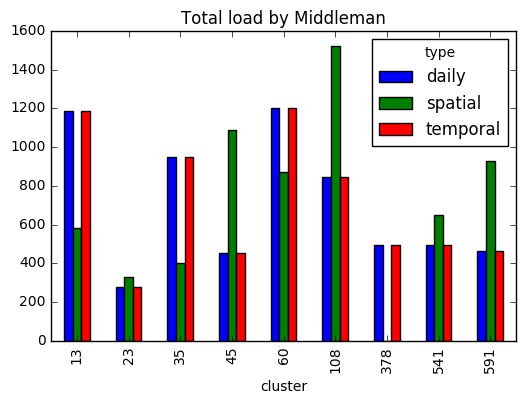

In [166]:
aux = cluster_df_temp_all.pivot(index='cluster', columns='type', values='load')
aux.index = aux.index.astype(int)
aux.sort_index().plot.bar(title = "Total load by Middleman")

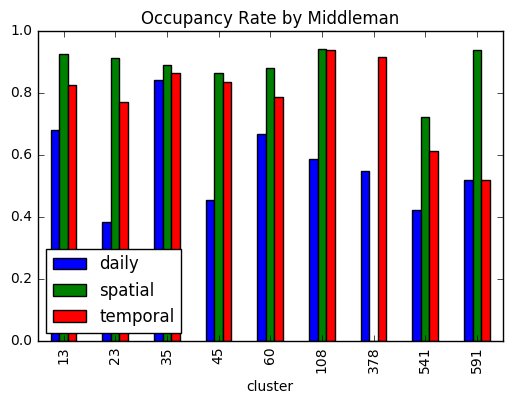

In [170]:
aux = cluster_df_temp_all.pivot(index='cluster', columns='type', values='load_perc_occupied')
aux.index = aux.index.astype(int)
ax = aux.sort_index().plot.bar(title = "Occupancy Rate by Middleman")
ax.legend(loc = "lower left")

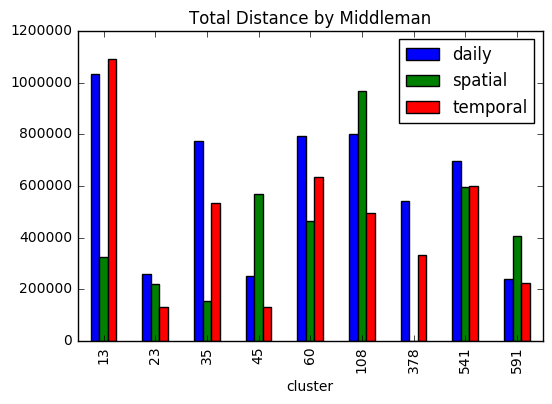

In [174]:
aux = cluster_df_temp_all.pivot(index='cluster', columns='type', values='distance')
aux.index = aux.index.astype(int)
ax = aux.sort_index().plot.bar(title = "Total Distance by Middleman")
ax.legend(loc = "upper right")

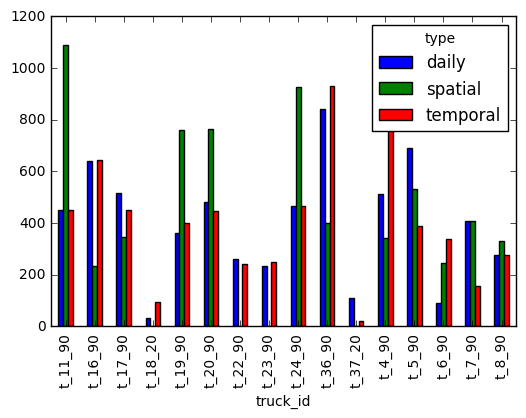

In [129]:
# Load by truck
aux = truck_loads_df_full[truck_loads_df_full['load']>0]
df1 = pd.DataFrame(aux.groupby(['truck_id','type'])['load'].sum())
df2 = pd.DataFrame(aux.groupby(['truck_id'])['capacity'].first())
joined = df1.join(df2).reset_index()
joined['truck_id'] = joined['truck_id'] + '_'+joined['capacity'].apply(str)
joined.pivot(index='truck_id', columns='type', values='load').plot.bar()

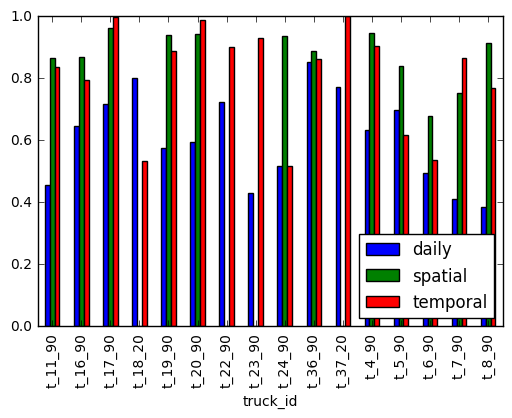

In [148]:
# Load percentage by truck
aux = truck_loads_df_full[truck_loads_df_full['load']>0]
df1 = pd.DataFrame(aux.groupby(['truck_id','type'])['load'].sum()/aux.groupby(['truck_id','type'])['max_load'].sum())
df1 = df1.rename(columns={0:'load_perc'})
df2 = pd.DataFrame(aux.groupby(['truck_id'])['capacity'].first())
joined = df1.join(df2).reset_index()
joined['truck_id'] = joined['truck_id'] + '_'+joined['capacity'].apply(str)
ax = joined.pivot(index='truck_id', columns='type', values='load_perc').plot.bar()
ax.legend(loc='lower right')

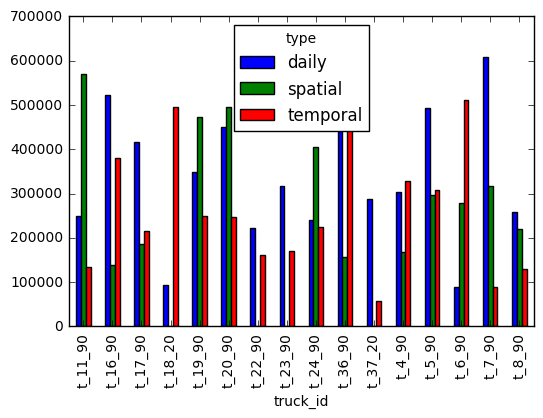

In [176]:
# Load by truck
aux = truck_loads_df_full[truck_loads_df_full['load']>0]
df1 = pd.DataFrame(aux.groupby(['truck_id','type'])['distance'].sum())
df2 = pd.DataFrame(aux.groupby(['truck_id'])['capacity'].first())
joined = df1.join(df2).reset_index()
joined['truck_id'] = joined['truck_id'] + '_'+joined['capacity'].apply(str)
joined.pivot(index='truck_id', columns='type', values='distance').plot.bar()

In [178]:
dim_middlemen

,cluster_id,latitude,longitude,mills,MM # of trucks (9 ton),MM # of pickups (2 ton),MM # doble (1 ton),trucks
0,33,-0.741099,102.524522,SKIP NHR,2,0,2,"{'9':2,'2':0,'1':2}"
1,60,-0.751465,102.534405,SRJ SKIP NHR BIM BSS,2,0,0,"{'9':2,'2':0,'1':0}"
2,541,-0.630413,102.429045,SKIP NHR Arvena,2,0,0,"{'9':2,'2':0,'1':0}"
3,23,-0.686109,102.436898,SKIP,1,0,0,"{'9':1,'2':0,'1':0}"
4,258,-0.661545,102.442983,SKIP NHR Arvena,1,1,0,"{'9':1,'2':1,'1':0}"
5,45,-0.711308,102.527174,SKIP NHR,1,0,0,"{'9':1,'2':0,'1':0}"
6,46,-0.661218,102.444760,SKIP NHR Arvena,1,0,2,"{'9':1,'2':0,'1':2}"
7,5,-0.692680,102.437734,SKIP NHR,1,0,0,"{'9':1,'2':0,'1':0}"
8,13,-0.682414,102.546902,SKIP NHR BSS,2,1,0,"{'9':2,'2':1,'1':0}"
9,108,-0.654447,102.574481,SRJ SKIP NHR,2,0,0,"{'9':2,'2':0,'1':0}"


In [186]:
dim_trucks[[row['truck_id'] in truck_loads_df_full.truck_id.values for i,row in dim_trucks.iterrows() ]].sort_values(by=['cluster_id','truck_id'])

,capacity,cluster_id,truck_id
16,9,13,t_16
17,9,13,t_17
18,2,13,t_18
8,9,23,t_8
34,9,35,t_36
35,2,35,t_37
11,9,45,t_11
4,9,60,t_4
5,9,60,t_5
19,9,108,t_19


In [190]:
dim_middlemen[[row['cluster_id'] in truck_loads_df_full.cluster.values for i,row in dim_middlemen.iterrows() ]].sort_values(by=['cluster_id'])[['cluster_id','trucks']]

,cluster_id,trucks
9,108,"{'9':2,'2':0,'1':0}"
8,13,"{'9':2,'2':1,'1':0}"
3,23,"{'9':1,'2':0,'1':0}"
18,35,"{'9':1,'2':1,'1':0}"
11,378,"{'9':2,'2':0,'1':0}"
5,45,"{'9':1,'2':0,'1':0}"
2,541,"{'9':2,'2':0,'1':0}"
12,591,"{'9':1,'2':0,'1':0}"
1,60,"{'9':2,'2':0,'1':0}"
